In [28]:
!pip install chromadb pypdf sentence-transformers
!pip install matplotlib
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [29]:
!pip install chromadb sentence-transformers pypdf nltk


In [30]:
import os
import uuid
from typing import List

import chromadb
from chromadb.config import Settings
from pypdf import PdfReader
from sentence_transformers import SentenceTransformer

In [31]:
PDF_FOLDER = "cvs"      # folder containing your CV PDFs
CHROMA_DIR = "chroma_cv_db"  # where Chroma will store its files
COLLECTION_NAME = "cv_chunks"


MIN_CHUNK_CHARS = 300      # minimum size after merging
MAX_CHUNK_CHARS = 1200     # max safety cap to avoid huge chunks

In [32]:
client = chromadb.PersistentClient(
    path=CHROMA_DIR,
    
)


collection = client.get_or_create_collection(
    name=COLLECTION_NAME,
    
)


embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [33]:
def read_pdf_text(path: str) -> str:
    reader = PdfReader(path)
    pages_text = []
    for page in reader.pages:
        pages_text.append(page.extract_text() or "")
    return "\n".join(pages_text)


In [34]:
def split_to_paragraphs(text: str) -> List[str]:
    
    raw_paras = [p.strip() for p in text.split("\n\n")]
    return [p for p in raw_paras if p]

In [35]:
from nltk.tokenize import sent_tokenize

def chunk_text_semantic(text: str,
                        max_chars: int = 800,
                        min_chars: int = 300):
 
    sentences = sent_tokenize(text)
    chunks = []
    current = ""

    for sent in sentences:
        if len(current) + len(sent) + 1 <= max_chars:
            current += (" " if current else "") + sent
        else:
            if len(current) >= min_chars:
                chunks.append(current)
                current = sent
            else:
                
                current += (" " if current else "") + sent

    if current.strip():
        chunks.append(current)

    return chunks


In [36]:
def semantic_chunk(text: str) -> List[str]:
    paragraphs = split_to_paragraphs(text)
    if not paragraphs:
        return []
    return merge_paragraphs_to_chunks(paragraphs)

In [37]:
def index_all_pdfs(pdf_dir: str):
    all_docs = []
    all_ids = []
    all_metas = []

    for filename in os.listdir(pdf_dir):
        if not filename.lower().endswith(".pdf"):
            continue

        path = os.path.join(pdf_dir, filename)
        print(f"[+] Reading {path}")
        raw_text = read_pdf_text(path)

        chunks = chunk_text_semantic(raw_text)
        print(f"    -> {len(chunks)} chunks")

        for i, chunk in enumerate(chunks):
            chunk_id = str(uuid.uuid4())
            all_ids.append(chunk_id)
            all_docs.append(chunk)
            all_metas.append({
                "source_file": filename,
                "chunk_index": i
            })

    if not all_docs:
        print("No documents to add!")
        return

    print(f"[+] Embedding {len(all_docs)} chunks...")
    embeddings = embedder.encode(all_docs).tolist()

    print("[+] Saving to Chroma...")
    collection.add(
        ids=all_ids,
        documents=all_docs,
        metadatas=all_metas,
        embeddings=embeddings,
    )
    print("[✓] Done. Chunks in collection:", collection.count())



index_all_pdfs(PDF_FOLDER)


[+] Reading cvs\cv_training.pdf
    -> 3 chunks
[+] Reading cvs\cv`.pdf
    -> 5 chunks
[+] Reading cvs\ToqaAsedahCV (2).pdf
    -> 5 chunks
[+] Embedding 13 chunks...
[+] Saving to Chroma...
[✓] Done. Chunks in collection: 183


In [38]:


def index_single_pdf(pdf_path):
    
    print(f"Indexing: {pdf_path}")
    
    pass

def index_all_pdfs(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith('.pdf')]
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_folder, pdf_file)
        index_single_pdf(pdf_path)



In [39]:
if __name__ == "__main__":
    index_all_pdfs(PDF_FOLDER)
    print("Finished indexing all CV PDFs into Chroma.")


Indexing: cvs\cv_training.pdf
Indexing: cvs\cv`.pdf
Indexing: cvs\ToqaAsedahCV (2).pdf
Finished indexing all CV PDFs into Chroma.


In [40]:
query = "Senior backend Java developer with Spring Boot and microservices"
query_embed = embedder.encode([query]).tolist()[0]

results = collection.query(
    query_embeddings=[query_embed],
    n_results=5,
)

for doc, meta, dist in zip(
    results["documents"][0],
    results["metadatas"][0],
    results["distances"][0],
):
    print("----")
    print("Source:", meta["source_file"], " | Chunk:", meta["chunk_index"], " | Score:", dist)
    print(doc[:300], "...")


----
Source: cv`.pdf  | Chunk: 3  | Score: 0.648133397102356
The
 
frontend
 
uses
 
EJS
 
templates
 
and
 
Bootstrap
 
for
 
a
 
responsive
 
UI.The
 
project
 
follows
 
MVC
 
architecture
 
with
 
dedicated
 
controllers,
 
models,
 
and
 
routes. Environment
 
variables
 
are
 
managed
 
via
 
dotenv,
 
and
 
the
 
development
 
workflow
 
uses
 
Nodemon ...
----
Source: cv`.pdf  | Chunk: 3  | Score: 0.648133397102356
The
 
frontend
 
uses
 
EJS
 
templates
 
and
 
Bootstrap
 
for
 
a
 
responsive
 
UI.The
 
project
 
follows
 
MVC
 
architecture
 
with
 
dedicated
 
controllers,
 
models,
 
and
 
routes. Environment
 
variables
 
are
 
managed
 
via
 
dotenv,
 
and
 
the
 
development
 
workflow
 
uses
 
Nodemon ...
----
Source: cv`.pdf  | Chunk: 3  | Score: 0.648133397102356
The
 
frontend
 
uses
 
EJS
 
templates
 
and
 
Bootstrap
 
for
 
a
 
responsive
 
UI.The
 
project
 
follows
 
MVC
 
architecture
 
with
 
dedicated
 
controllers,
 
models,
 
and
 
routes. Environment
 
va

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [ ]:
try:
    with open('rag_evaluation.json', 'r', encoding='utf-8') as f:
        file_content = f.read()
        exec(file_content)  
    print(f"Successfully loaded {len(EVAL_QUERIES)} evaluation queries.")
except FileNotFoundError:
    print("Error: 'rag_evaluation.json' not found. Make sure the file is in the same folder.")
    
    EVAL_QUERIES = []
    

Successfully loaded 53 evaluation queries.


In [45]:




FILE_MAPPING = {
    "Ibrahim":"cv`",
     "Toqa": "ToqaAsedah",     
    "Rama": "cv_training",  
}


THRESHOLD = 1.1


def evaluate_retrieval(collection, queries, file_mapping, threshold=1.1):
    y_true = [] # 1 = Expect Answer, 0 = Expect Nothing (Negative Query)
    y_pred = [] # 1 = Found Relevant Doc, 0 = Found Nothing / Irrelevant
    
    print(f"{'ID':<25} {'Category':<15} {'Expect':<8} {'Found':<8} {'Dist':<6} {'Result'}")
    print("-" * 90)

    for q in queries:
        query_text = q['question']
        category = q.get('category', 'direct')
        metadata = q.get('gold_metadata', {})
        
        
        expect_answer = 0 if category == 'negative' else 1
        y_true.append(expect_answer)
        
      
        query_vec = embedder.encode([query_text]).tolist()[0]
        
        results = collection.query(
            query_embeddings=[query_vec],
            n_results=1  
        )
        
        
        found_relevant = 0
        min_dist = 999.0
        
        if results['documents'] and len(results['documents'][0]) > 0:
            top_dist = results['distances'][0][0]
            top_file = results['metadatas'][0][0]['source_file']
            min_dist = top_dist
            
           
            target_candidate = metadata.get('candidate')
            is_candidate_match = True
            if target_candidate:
                
                expected_part = file_mapping.get(target_candidate, "")
                if expected_part and expected_part.lower() not in top_file.lower():
                    is_candidate_match = False
            
            
            if top_dist < threshold and is_candidate_match:
                found_relevant = 1
            else:
                found_relevant = 0
        
        y_pred.append(found_relevant)
        
        
        outcome = "TN"
        if expect_answer == 1 and found_relevant == 1: outcome = "TP"
        elif expect_answer == 0 and found_relevant == 1: outcome = "FP" # Hallucination / Wrong Retrieval
        elif expect_answer == 1 and found_relevant == 0: outcome = "FN" # Missed Answer
        
        print(f"{q['id']:<25} {category:<15} {expect_answer:<8} {found_relevant:<8} {min_dist:.3f}   {outcome}")

    return y_true, y_pred





ID                        Category        Expect   Found    Dist   Result
------------------------------------------------------------------------------------------
q1_email_rama             direct          1        0        0.761   FN
q2_uni_ibrahim            direct          1        0        0.694   FN
q3_gpa_rama               direct          1        1        0.629   TP
q4_langs_ibrahim          direct          1        1        0.600   TP
q5_skills_rama            direct          1        0        0.521   FN
q6_phone_ibrahim          direct          1        1        0.723   TP
q7_backend_date_rama      direct          1        1        0.480   TP
q8_internship_ibrahim     experience      1        1        0.567   TP
q9_fetal_health_rama      experience      1        1        0.676   TP
q10_cap_advisor_tech_ibrahim experience      1        0        0.610   FN
q11_messages_role_rama    experience      1        0        0.662   FN
q12_exalt_hours_rama      experience      1        

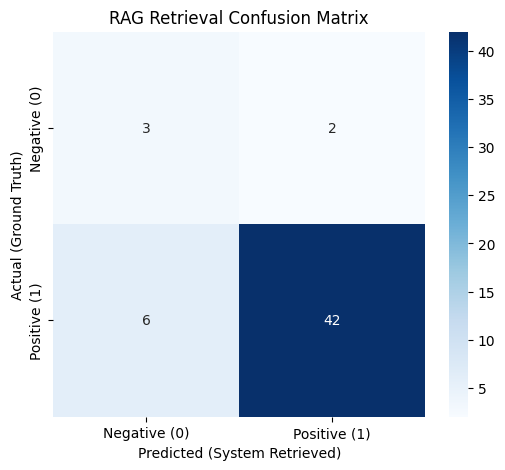

In [46]:
if EVAL_QUERIES:
   
    y_true, y_pred = evaluate_retrieval(collection, EVAL_QUERIES, FILE_MAPPING, threshold=THRESHOLD)

    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n" + "="*30)
    print("CONFUSION MATRIX RESULTS")
    print("="*30)
    print(f"True Positives  (TP): {tp}  (Expected info correctly found)")
    print(f"False Positives (FP): {fp}  (Found info for negative query / Wrong doc)")
    print(f"True Negatives  (TN): {tn}  (Correctly found nothing for negative query)")
    print(f"False Negatives (FN): {fn}  (Failed to find existing info)")
    print("-" * 30)
    print(f"Accuracy:  {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 Score:  {f1:.2f}")

    
    plt.figure(figsize=(6, 5))
    labels = ['Negative (0)', 'Positive (1)']
    sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted (System Retrieved)')
    plt.ylabel('Actual (Ground Truth)')
    plt.title('RAG Retrieval Confusion Matrix')
    plt.show()
else:
    print("Skipping evaluation: EVAL_QUERIES is empty.")